In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score
import numpy as np

# Cargar datos
df_gemma = pd.read_excel("./datos/Clasificación_gemma2-9b-it-Completo.xlsx")
df_llama8b = pd.read_excel("./datos/Clasificación_llama-3.1-8b-instant-Completo.xlsx")
df_llama70b = pd.read_excel("./datos/Clasificación_llama-3.3-70b-versatile-Completo.xlsx")
df_gpt = pd.read_excel("./datos/Clasificación_GPT-4o-mini-Completo.xlsx")


In [3]:
true_col = 'Polarity'

prompt_cols_gemma = [
    'Polarity_gemma2-9b-it_ZeroShot',
    'Polarity_gemma2-9b-it_FewShot',
    'Polarity_gemma2-9b-it_Chain_Of_Thought'
]

prompt_cols_llama8b = [
    'Polarity_llama-3.1-8b-instant_ZeroShot',
    'Polarity_llama-3.1-8b-instant_FewShot',
    'Polarity_llama-3.1-8b-instant_Chain_Of_Thought'
]

prompt_cols_llama70b = [
    'Polarity_llama-3.3-70b-versatile_ZeroShot',
    'Polarity_llama-3.3-70b-versatile_FewShot',
    'Polarity_llama-3.3-70b-versatile_Chain_Of_Thought'
]

prompt_cols_gpt = [
    'Polarity_GPT-4o-mini_ZeroShot',
    'Polarity_GPT-4o-mini_FewShot',
    'Polarity_GPT-4o-mini_Chain_Of_Thought'
]

prompt_names = ['ZeroShot', 'FewShot', 'Chain of Thought']

expected_labels = {"NEG", "NEU", "POS"}

# Función para reemplazar etiquetas no válidas
def normalize_label(label):
    if pd.isna(label):
        return "INVAL"
    return label if label in expected_labels else "INVAL"


# Aplicar normalización al DataFrame
def normalize_dataframe(df, true_col, prompt_cols, normalize_label_func):
    df_normalized = df.copy()
    for col in [true_col] + prompt_cols:
        df_normalized[col] = df_normalized[col].apply(normalize_label_func)
    return df_normalized


df_normalized_gemma = normalize_dataframe(df_gemma, true_col, prompt_cols_gemma, normalize_label)
df_normalized_llama8b = normalize_dataframe(df_llama8b, true_col, prompt_cols_llama8b, normalize_label)
df_normalized_llama70b = normalize_dataframe(df_llama70b, true_col, prompt_cols_llama70b, normalize_label)
df_normalized_gpt = normalize_dataframe(df_gpt, true_col, prompt_cols_gpt, normalize_label)


In [4]:
def plot_aciertos_by_prompt(df_normalized, true_col, prompt_cols, prompt_names, model_name):
    # Calcular porcentaje de aciertos globales
    global_aciertos_results = []
    for col, name in zip(prompt_cols, prompt_names):
        correct = (df_normalized[col] == df_normalized[true_col]) & (df_normalized[true_col] != "INVAL")
        total_valid = (df_normalized[true_col] != "INVAL").sum()
        accuracy = correct.sum() / total_valid * 100
        global_aciertos_results.append((name, accuracy))
    
    # Calcular porcentaje de aciertos por polaridad
    polarity_aciertos_results = {label: [] for label in ["NEG", "NEU", "POS"]}
    for col, name in zip(prompt_cols, prompt_names):
        for label in ["NEG", "NEU", "POS"]:
            correct = (df_normalized[col] == df_normalized[true_col]) & (df_normalized[true_col] == label)
            total_label = (df_normalized[true_col] == label).sum()
            accuracy = correct.sum() / total_label * 100 if total_label > 0 else 0
            polarity_aciertos_results[label].append((name, accuracy))  #no es recall ni precision, es el porcentaje de aciertos por polaridad
            #calculamos el recall aunque no queramos ya que: verdaderos positivos / verdadedros reales
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(global_aciertos_results)) 
    width = 0.2 
    global_bars = ax.bar(x - width, [x[1] for x in global_aciertos_results], width, label='Global', color='grey')

    colors = {'NEG': 'red', 'NEU': 'lightblue', 'POS': 'lightgreen'}
    for i, label in enumerate(["NEG", "NEU", "POS"]):
        polar_bars = ax.bar(x + i * width, [x[1] for x in polarity_aciertos_results[label]], width, label=label, color=colors[label])

    ax.set_xlabel('Prompts')
    ax.set_ylabel('Porcentaje de aciertos (%)')
    ax.set_title(f'Porcentaje de aciertos por prompt y polaridad - {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels([x[0] for x in global_aciertos_results])
    ax.set_ylim(0, 100)
    ax.legend(title="Tipo de precisión")
    ax.grid(axis='y')
    
    for bars in [global_bars] + [ax.patches[i::len(global_aciertos_results)] for i in range(1, 4)]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [5]:
def plot_confusion_matrices(df, true_col, prompt_cols, prompt_names, model_name):
    filtered_df = df[[true_col] + prompt_cols].dropna()

    # Generar matrices de respuestas (matrices de confusión)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, col, name in zip(axes, prompt_cols, prompt_names):
        cm = confusion_matrix(filtered_df[true_col], filtered_df[col], labels=["NEG", "NEU", "POS"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG", "NEU", "POS"])
        disp.plot(ax=ax, values_format='d', cmap='Blues')
        ax.set_title(f'Matriz de confusión - {name} ({model_name})')
    plt.tight_layout()
    plt.show()

In [7]:
def calculate_metrics(df_normalized, prompt_cols, model_name, true_col, prompt_names, expected_labels):
    metrics_manual = []

    for col, name in zip(prompt_cols, prompt_names):
        for label in expected_labels:
            # Verdaderos positivos
            tp = ((df_normalized[true_col] == label) & (df_normalized[col] == label)).sum()
            # Verdaderos negativos
            tn = ((df_normalized[true_col] != label) & (df_normalized[col] != label)).sum()
            # Falsos positivos
            fp = ((df_normalized[true_col] != label) & (df_normalized[col] == label)).sum()
            # Falsos negativos
            fn = ((df_normalized[true_col] == label) & (df_normalized[col] != label)).sum()

            accuracy_binaria = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
            accuracy_global = accuracy_score(df_normalized[true_col], df_normalized[col], normalize=True, sample_weight=None)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 1.0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            metrics_manual.append({
                "Modelo": model_name,
                "Prompt": name,
                "Clase": label,
                "Accuracy Global": round(accuracy_global, 2),
                "Accuracy Binaria": round(accuracy_binaria, 2),
                "Precisión": round(precision, 2),
                "Recall": round(recall, 2),
                "F1-score": round(f1, 2)
            })

    return pd.DataFrame(metrics_manual)

In [8]:
# Accuacy: verdaderos positivos + verdaderos negativos / total de muestras
# Precision: verdaderos positivos / (verdaderos positivos + falsos positivos)
# Recall: verdaderos positivos / (verdaderos positivos + falsos negativos)
# F1: 2 * (precision * recall) / (precision + recall)

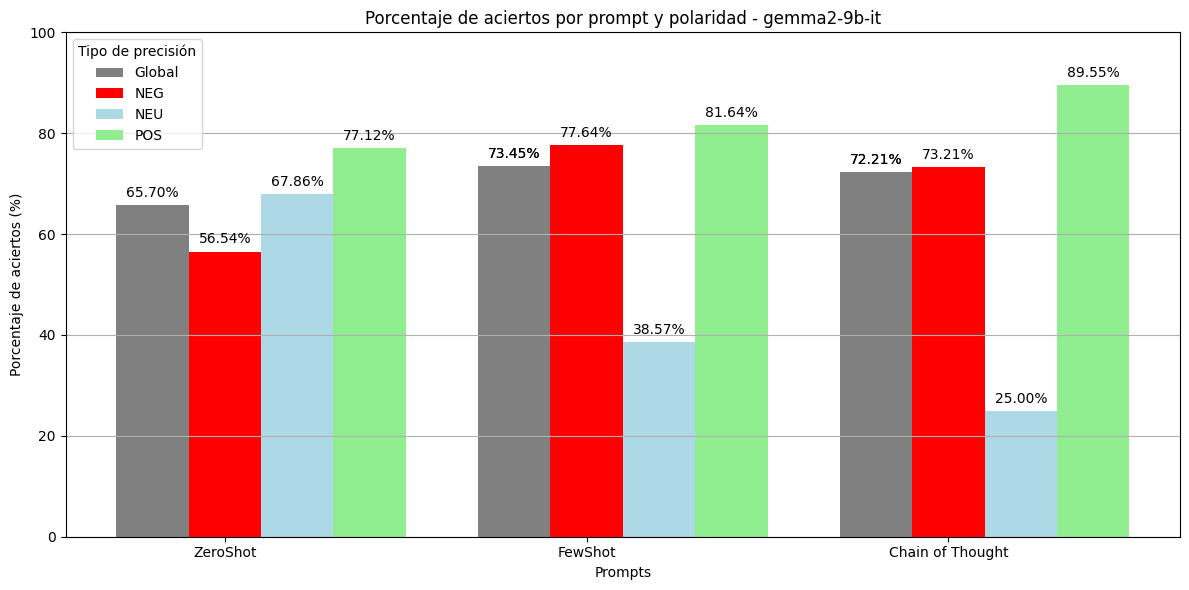

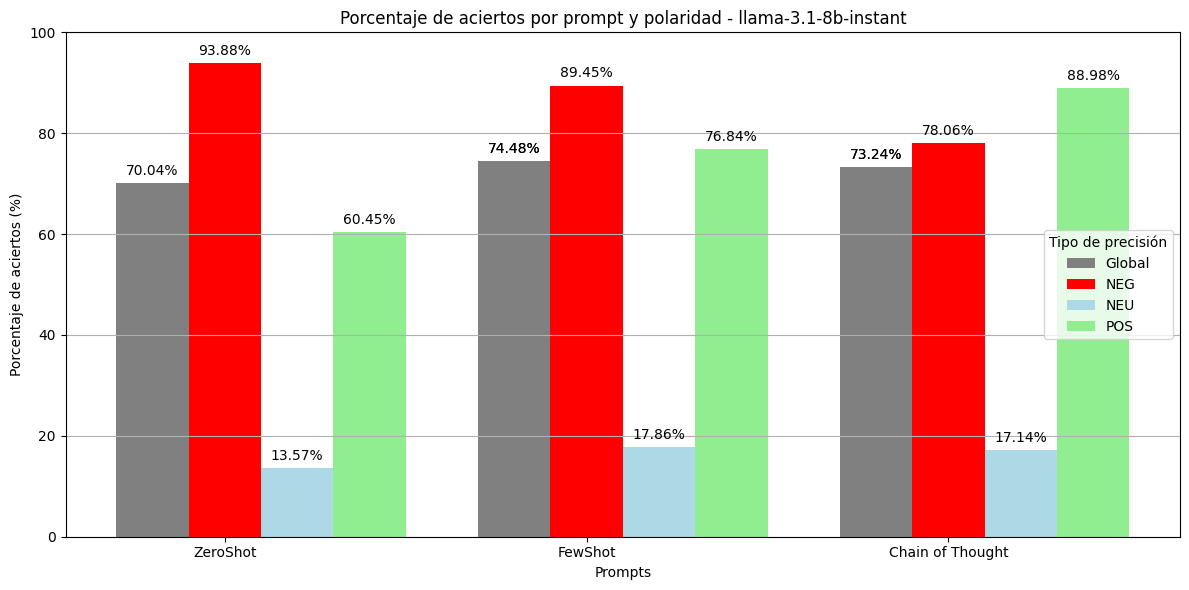

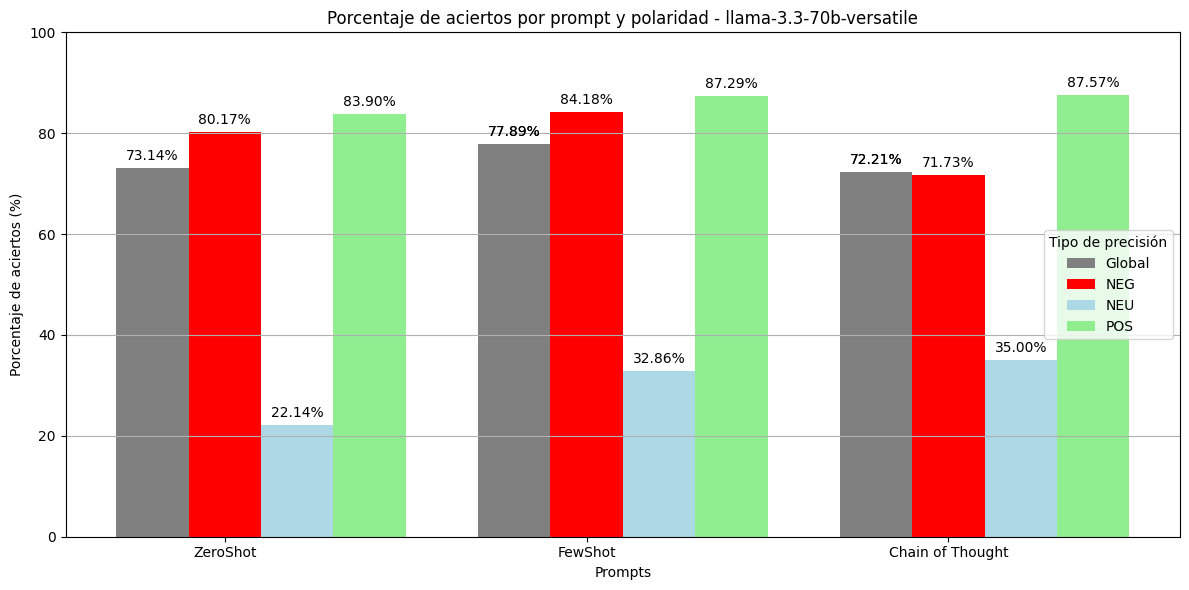

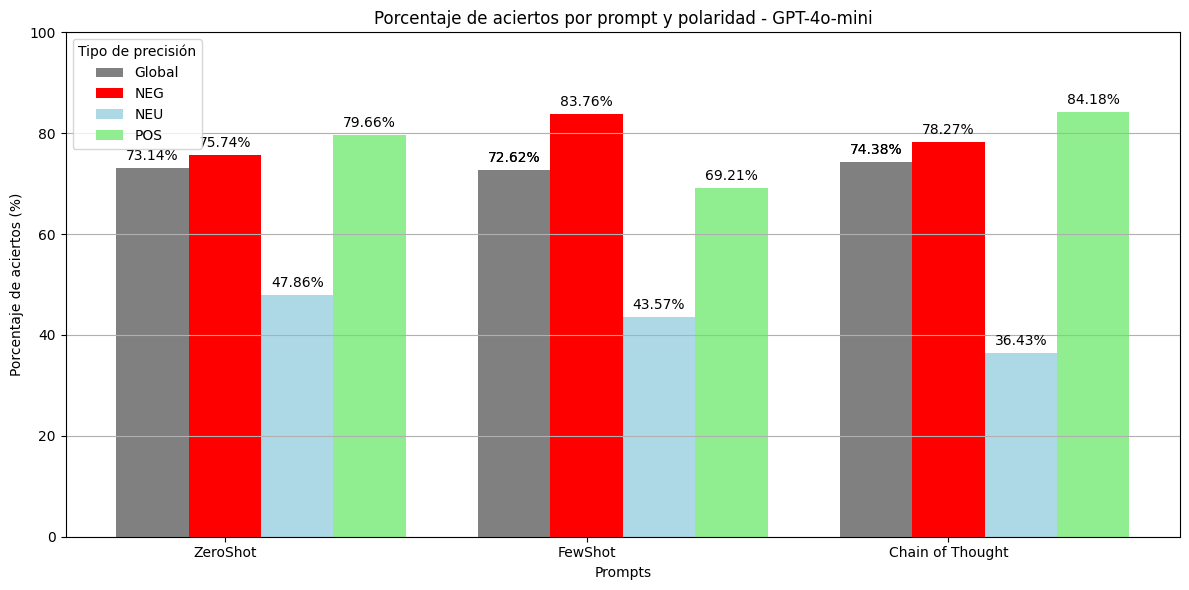

In [9]:
plot_aciertos_by_prompt(df_normalized_gemma, true_col, prompt_cols_gemma, prompt_names, "gemma2-9b-it")
plot_aciertos_by_prompt(df_normalized_llama8b, true_col, prompt_cols_llama8b, prompt_names, "llama-3.1-8b-instant")
plot_aciertos_by_prompt(df_normalized_llama70b, true_col, prompt_cols_llama70b, prompt_names, "llama-3.3-70b-versatile")
plot_aciertos_by_prompt(df_normalized_gpt, true_col, prompt_cols_gpt, prompt_names, "GPT-4o-mini")

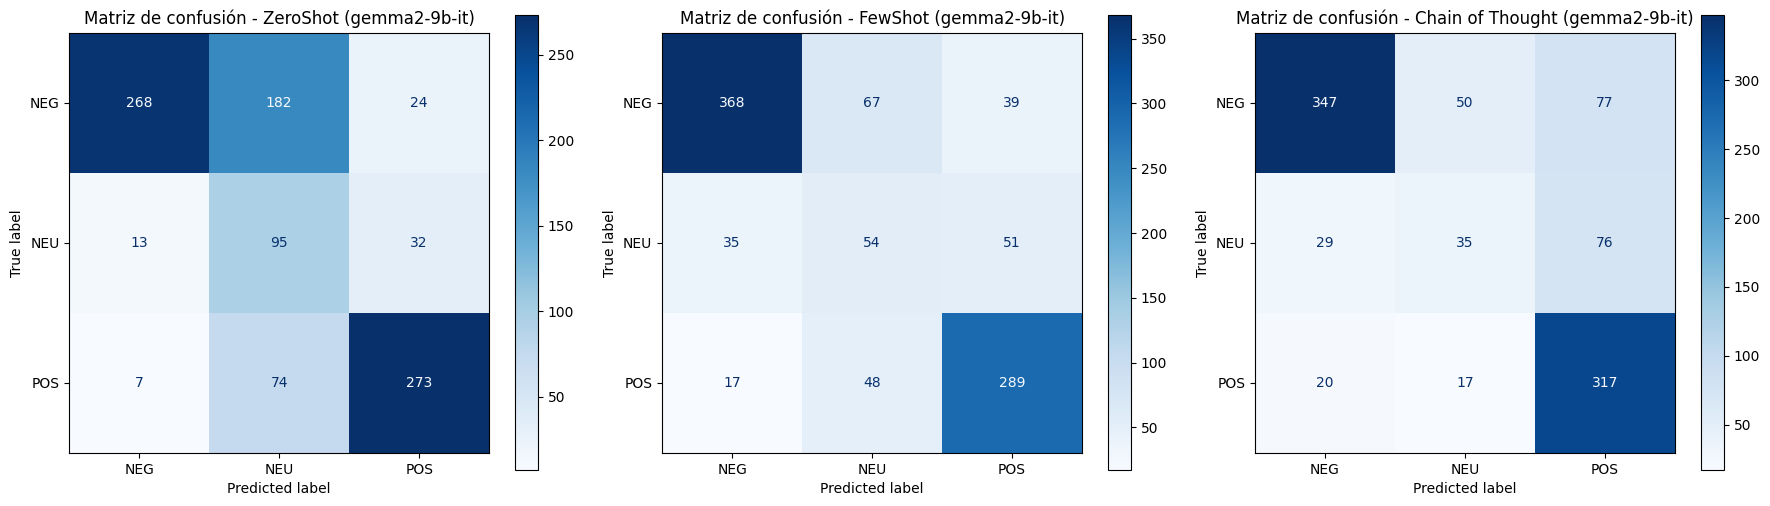

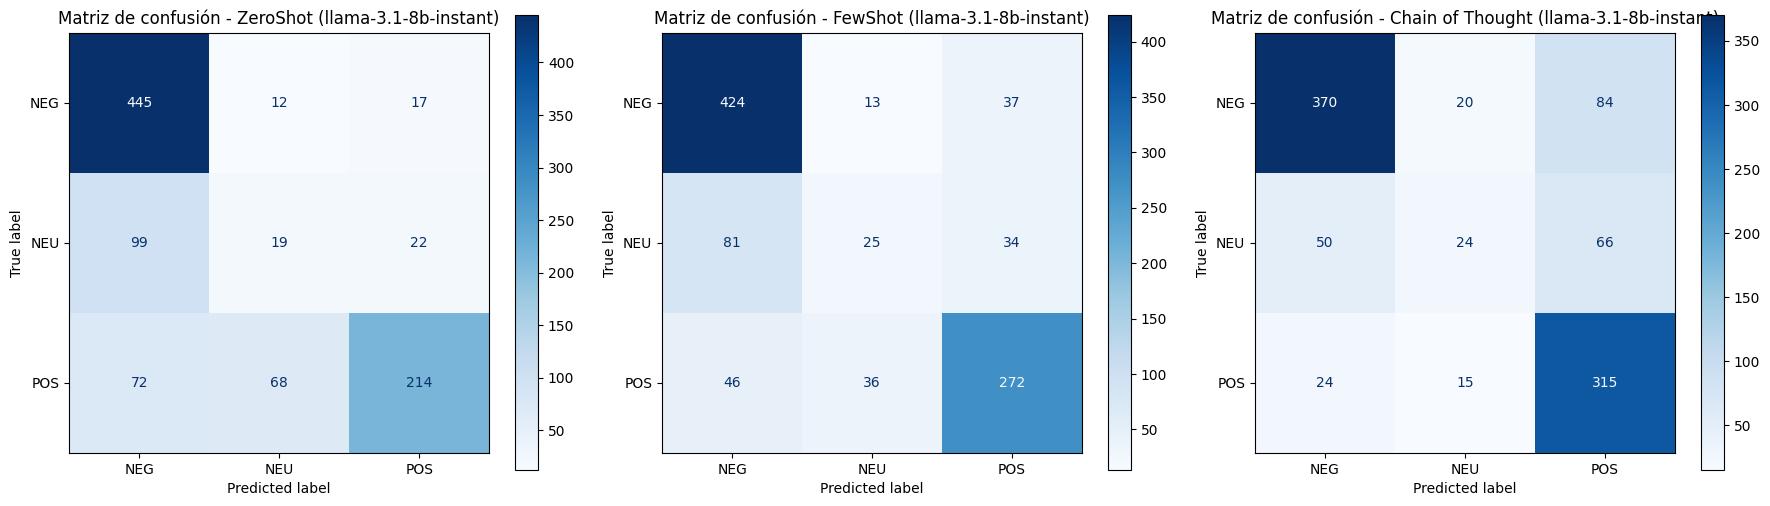

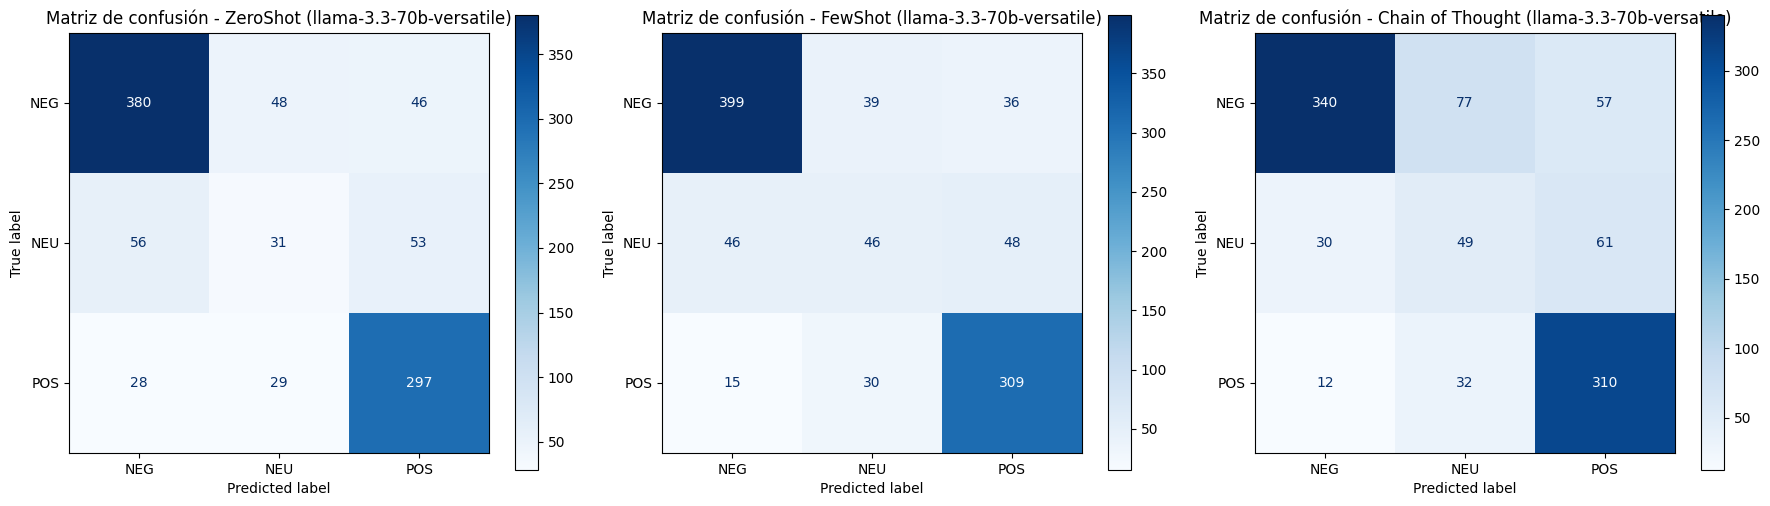

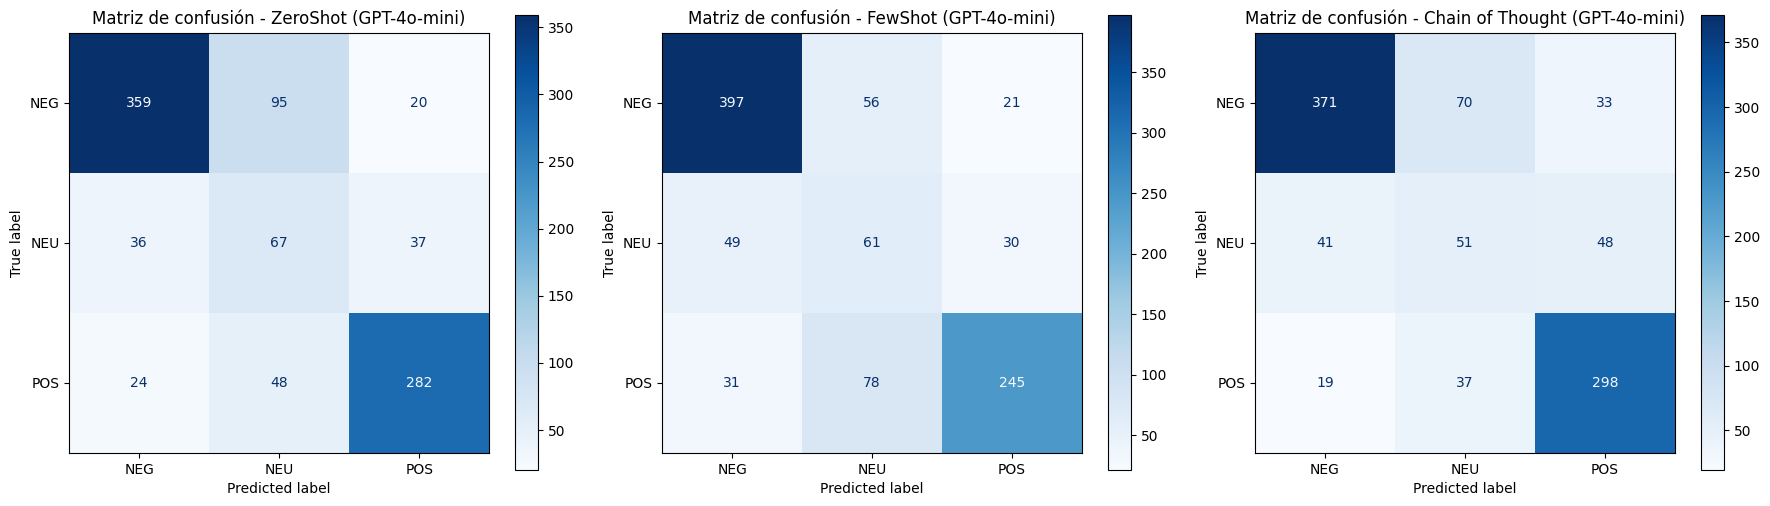

In [10]:
plot_confusion_matrices(df_normalized_gemma, true_col, prompt_cols_gemma, prompt_names, "gemma2-9b-it")
plot_confusion_matrices(df_normalized_llama8b, true_col, prompt_cols_llama8b, prompt_names, "llama-3.1-8b-instant")
plot_confusion_matrices(df_normalized_llama70b, true_col, prompt_cols_llama70b, prompt_names, "llama-3.3-70b-versatile")
plot_confusion_matrices(df_normalized_gpt, true_col, prompt_cols_gpt, prompt_names, "GPT-4o-mini")

In [12]:
metrics_df_gemma = calculate_metrics(df_normalized_gemma, prompt_cols_gemma, "gemma2-9b-it", true_col, prompt_names, expected_labels)
metrics_df_gemma

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,gemma2-9b-it,ZeroShot,NEU,0.66,0.69,0.27,0.68,0.39
1,gemma2-9b-it,ZeroShot,NEG,0.66,0.77,0.93,0.57,0.70
2,gemma2-9b-it,ZeroShot,POS,0.66,0.86,0.83,0.77,0.80
3,gemma2-9b-it,FewShot,NEU,0.73,0.79,0.32,0.39,0.35
4,gemma2-9b-it,FewShot,NEG,0.73,0.84,0.88,0.78,0.82
5,gemma2-9b-it,FewShot,POS,0.73,0.84,0.76,0.82,0.79
6,gemma2-9b-it,Chain of Thought,NEU,0.72,0.82,0.34,0.25,0.29
7,gemma2-9b-it,Chain of Thought,NEG,0.72,0.82,0.88,0.73,0.80
8,gemma2-9b-it,Chain of Thought,POS,0.72,0.80,0.67,0.90,0.77


In [13]:
metrics_df_gpt = calculate_metrics(df_normalized_gpt, prompt_cols_gpt, "GPT-4o-mini", true_col, prompt_names, expected_labels)
metrics_df_gpt

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,GPT-4o-mini,ZeroShot,NEU,0.73,0.78,0.32,0.48,0.38
1,GPT-4o-mini,ZeroShot,NEG,0.73,0.82,0.86,0.76,0.80
2,GPT-4o-mini,ZeroShot,POS,0.73,0.87,0.83,0.80,0.81
3,GPT-4o-mini,FewShot,NEU,0.73,0.78,0.31,0.44,0.36
4,GPT-4o-mini,FewShot,NEG,0.73,0.84,0.83,0.84,0.83
5,GPT-4o-mini,FewShot,POS,0.73,0.83,0.83,0.69,0.75
6,GPT-4o-mini,Chain of Thought,NEU,0.74,0.80,0.32,0.36,0.34
7,GPT-4o-mini,Chain of Thought,NEG,0.74,0.83,0.86,0.78,0.82
8,GPT-4o-mini,Chain of Thought,POS,0.74,0.86,0.79,0.84,0.81


In [14]:
metrics_df_llama8b = calculate_metrics(df_normalized_llama8b, prompt_cols_llama8b, "llama-3.1-8b-instant", true_col, prompt_names, expected_labels)
metrics_df_llama8b

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,llama-3.1-8b-instant,ZeroShot,NEU,0.70,0.79,0.19,0.14,0.16
1,llama-3.1-8b-instant,ZeroShot,NEG,0.70,0.79,0.72,0.94,0.82
2,llama-3.1-8b-instant,ZeroShot,POS,0.70,0.82,0.85,0.60,0.71
3,llama-3.1-8b-instant,FewShot,NEU,0.74,0.83,0.34,0.18,0.23
4,llama-3.1-8b-instant,FewShot,NEG,0.74,0.82,0.77,0.89,0.83
5,llama-3.1-8b-instant,FewShot,POS,0.74,0.84,0.79,0.77,0.78
6,llama-3.1-8b-instant,Chain of Thought,NEU,0.73,0.84,0.41,0.17,0.24
7,llama-3.1-8b-instant,Chain of Thought,NEG,0.73,0.82,0.83,0.78,0.81
8,llama-3.1-8b-instant,Chain of Thought,POS,0.73,0.80,0.68,0.89,0.77


In [15]:
metrics_df_llama70b = calculate_metrics(df_normalized_llama70b, prompt_cols_llama70b, "llama-3.3-70b-versatile", true_col, prompt_names, expected_labels)
metrics_df_llama70b

,Modelo,Prompt,Clase,Accuracy Global,Accuracy Binaria,Precisión,Recall,F1-score
0,llama-3.3-70b-versatile,ZeroShot,NEU,0.73,0.81,0.29,0.22,0.25
1,llama-3.3-70b-versatile,ZeroShot,NEG,0.73,0.82,0.82,0.80,0.81
2,llama-3.3-70b-versatile,ZeroShot,POS,0.73,0.84,0.75,0.84,0.79
3,llama-3.3-70b-versatile,FewShot,NEU,0.78,0.83,0.40,0.33,0.36
4,llama-3.3-70b-versatile,FewShot,NEG,0.78,0.86,0.87,0.84,0.85
5,llama-3.3-70b-versatile,FewShot,POS,0.78,0.87,0.79,0.87,0.83
6,llama-3.3-70b-versatile,Chain of Thought,NEU,0.72,0.79,0.31,0.35,0.33
7,llama-3.3-70b-versatile,Chain of Thought,NEG,0.72,0.82,0.89,0.72,0.79
8,llama-3.3-70b-versatile,Chain of Thought,POS,0.72,0.83,0.72,0.88,0.79
